Original Data Cross-Validation:
Mean Accuracy: 0.72, Standard Deviation: 0.06
Original Data Validation Split:
Accuracy: 0.77
Augmented Data Cross-Validation:
Mean Accuracy: 0.55, Standard Deviation: 0.06
Augmented Data Validation Split:
Accuracy: 0.69
Original Data Results:


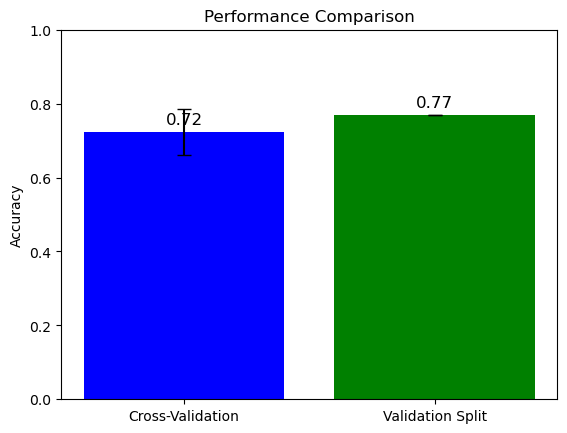

Augmented Data Results:


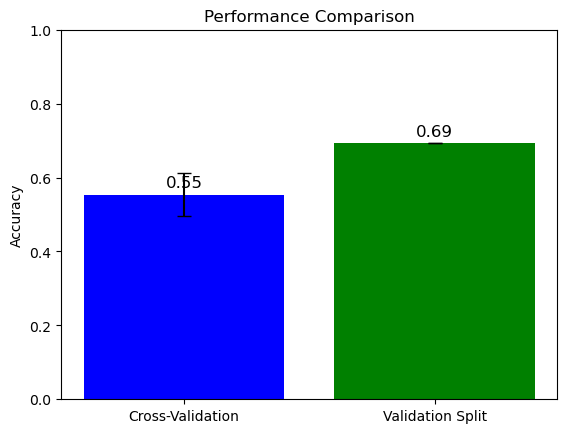

In [4]:
import os
import librosa
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#Load and Preprocess Data
def load_audio_data(folder_path):
    data = []
    labels = []
    for label, sub_folder in enumerate(['Animal Sounds', 'Environment']):
        path = os.path.join(folder_path, sub_folder)
        for file in os.listdir(path):
            if file.endswith('.wav'):
                file_path = os.path.join(path, file)
                y, sr = librosa.load(file_path, sr=None)
                features = librosa.feature.melspectrogram(y=y, sr=sr)
                data.append(np.mean(features, axis=1))  
                labels.append(label)
    return np.array(data), np.array(labels)

#Implement Audio Augmentation
def apply_audio_augmentations(X):
    augmenter = Compose([
        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
        TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        Shift(min_shift=-0.5, max_shift=0.5, p=0.5)  
    ])
    augmented_data = np.array([augmenter(samples=x, sample_rate=16000) for x in X])
    return augmented_data

#Build the Model
def build_model(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#Cross-Validation
def cross_validate(X, y, k=5, epochs=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in kf.split(X):
        model = build_model((X.shape[1], 1))
        model.fit(X[train_idx], y[train_idx], epochs=epochs, verbose=0)
        acc = model.evaluate(X[val_idx], y[val_idx], verbose=0)[1]
        accuracies.append(acc)

    return np.mean(accuracies), np.std(accuracies)

#Validation Split
def validation_split(X, y, epochs=10):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = build_model((X.shape[1], 1))
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    acc = model.evaluate(X_val, y_val, verbose=0)[1]
    return acc

#Visualization
def visualize_results(cross_val_results, val_result):
    methods = ['Cross-Validation', 'Validation Split']
    accuracies = [cross_val_results[0], val_result]
    error_bars = [cross_val_results[1], 0]  # Include error bar for cross-validation, none for validation split

    plt.bar(methods, accuracies, yerr=error_bars, color=['blue', 'green'], capsize=5)
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)
    plt.ylabel('Accuracy')
    plt.title('Performance Comparison')
    plt.show()


folder_path = r"C:\Users\User\Documents"  
X, y = load_audio_data(folder_path)
X_augmented = apply_audio_augmentations(X)

mean_acc, std_dev = cross_validate(X, y)
val_acc = validation_split(X, y)

# Print original data results
print("Original Data Cross-Validation:")
print(f"Mean Accuracy: {mean_acc:.2f}, Standard Deviation: {std_dev:.2f}")
print("Original Data Validation Split:")
print(f"Accuracy: {val_acc:.2f}")

mean_acc_aug, std_dev_aug = cross_validate(X_augmented, y)
val_acc_aug = validation_split(X_augmented, y)

# Print augmented data results
print("Augmented Data Cross-Validation:")
print(f"Mean Accuracy: {mean_acc_aug:.2f}, Standard Deviation: {std_dev_aug:.2f}")
print("Augmented Data Validation Split:")
print(f"Accuracy: {val_acc_aug:.2f}")

# Visualize results
print("Original Data Results:")
visualize_results((mean_acc, std_dev), val_acc)
print("Augmented Data Results:")
visualize_results((mean_acc_aug, std_dev_aug), val_acc_aug)
